<a href="https://colab.research.google.com/github/no1rabbit/Cloud_chasing/blob/main/NDVI_jupyternotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Now import TensorFlow and it will use CPU
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

from math import cos
from tqdm import tqdm
import os
import xarray as xr
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# view all the entire dataset not truncated
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

2.15.0
[]
Mounted at /content/drive


In [2]:
!git clone https://github.com/no1rabbit/Cloud_chasing.git

fatal: destination path 'Cloud_chasing' already exists and is not an empty directory.


In [3]:
%cd "/content/Cloud_chasing"

/content/Cloud_chasing


In [4]:
# Import functions from the script file
from cloud_functions import rotate_image_and_heading, train_and_visualize

In [5]:
# Define paths to your data
gps_file = 'data/Serengeti_HMM.csv'

# Load GPS data
gps_data = pd.read_csv(gps_file)
gps_data = gps_data[gps_data['case_'] == True]
gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)
gps_data = gps_data[gps_data['sp_m'] == 'WB_migrant']
gps_data['date1'] = pd.to_datetime(gps_data['date'])
gps_data['date'] = gps_data['date1'].dt.date
gps_data['month'] = gps_data['date1'].dt.month

gps_data = gps_data.sort_values(by=['ID','date'])

In [6]:
gps_data.head()

,ID,x1_,x2_,y1_,y2_,sl_,ta_,species,migrant,date,x,y,sex,dailystate,year,months,mon2,season,burst_,t1_,t2_,dt_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,sp_m,date1,month
0,SW100,680764.8743,674933.7549,9724120.192,9728178.122,7104.136073,-0.431814,WB,migrant,2021-12-13,-2.497654,34.626559,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-13T07:30:00Z,2021-12-14T07:30:00Z,86400,True,3,0.908208,8.868432,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-13,12
11,SW100,674933.7549,675019.5210,9728178.122,9727439.122,743.960230,2.294312,WB,migrant,2021-12-14,-2.461019,34.574084,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-14T07:30:00Z,2021-12-15T07:30:00Z,86400,True,4,-0.662023,6.611988,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-14,12
22,SW100,675019.5210,673586.9019,9727439.122,9726742.822,1592.868851,-1.233925,WB,migrant,2021-12-15,-2.467701,34.574863,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-15T07:30:00Z,2021-12-16T07:30:00Z,86400,True,5,0.330536,7.373292,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-15,12
33,SW100,673586.9019,669799.8705,9726742.822,9723233.359,5163.132516,0.294964,WB,migrant,2021-12-16,-2.474014,34.561989,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-16T07:30:00Z,2021-12-17T07:30:00Z,86400,True,6,0.956813,8.549299,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-16,12
44,SW100,669799.8705,666982.3274,9723233.359,9716497.189,7301.680313,0.427264,WB,migrant,2021-12-17,-2.505793,34.527973,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-17T07:30:00Z,2021-12-18T07:30:00Z,86400,True,7,0.910103,8.895860,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-17,12


In [7]:
##
#ds = xr.open_dataset('/content/drive/MyDrive/Cloud data/Serengeti_chirps_wide.nc')
ds = xr.open_dataset('/content/drive/MyDrive/wildebeest_data/serengeti_modis_UTM_2015-2023.nc')
ds


<xarray.Dataset>
Dimensions:      (y: 1528, x: 1346, time: 3275)
Coordinates:
  * y            (y) float64 9.935e+06 9.935e+06 ... 9.553e+06 9.553e+06
  * x            (x) float64 5.411e+05 5.414e+05 ... 8.771e+05 8.774e+05
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2023-12-19
    spatial_ref  int32 ...
Data variables:
    NDVI         (time, y, x) float64 ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

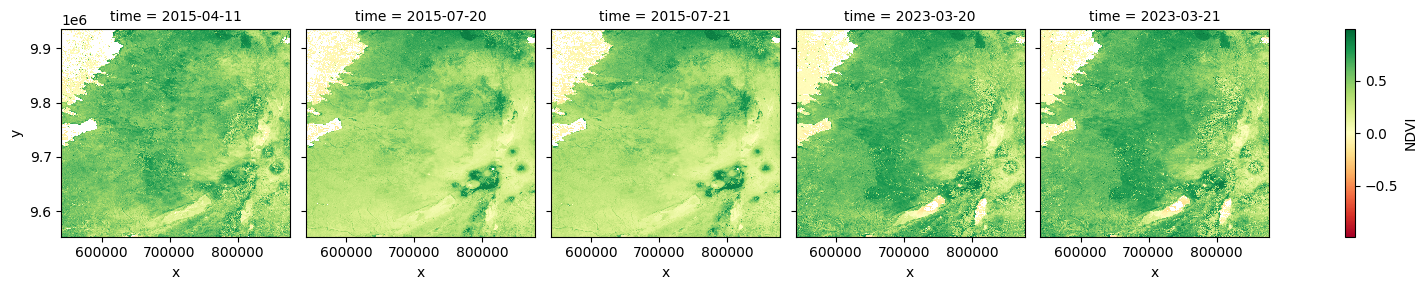

In [8]:
ds.NDVI.isel(time = [100,200,201,3000,3001]).plot(col='time',col_wrap = 5, cmap='RdYlGn')

100%|██████████| 59/59 [07:31<00:00,  7.66s/it]


Epoch 1/100
50/50 [==============================] - 22s 411ms/step - loss: -0.0352 - val_loss: -0.0131
Epoch 2/100
50/50 [==============================] - 20s 395ms/step - loss: -0.0426 - val_loss: -0.0123
Epoch 3/100
50/50 [==============================] - 19s 388ms/step - loss: -0.0426 - val_loss: -0.0139
Epoch 4/100
50/50 [==============================] - 20s 396ms/step - loss: -0.0425 - val_loss: -0.0141
Epoch 5/100
50/50 [==============================] - 19s 390ms/step - loss: -0.0426 - val_loss: -0.0137
Epoch 6/100
50/50 [==============================] - 19s 388ms/step - loss: -0.0429 - val_loss: -0.0124
Epoch 7/100
50/50 [==============================] - 20s 391ms/step - loss: -0.0432 - val_loss: -0.0169
Epoch 8/100
50/50 [==============================] - 19s 389ms/step - loss: -0.0447 - val_loss: -0.0066
Epoch 9/100
50/50 [==============================] - 20s 400ms/step - loss: -0.0438 - val_loss: -0.0174
Epoch 10/100
50/50 [==============================] - 19s 391ms/

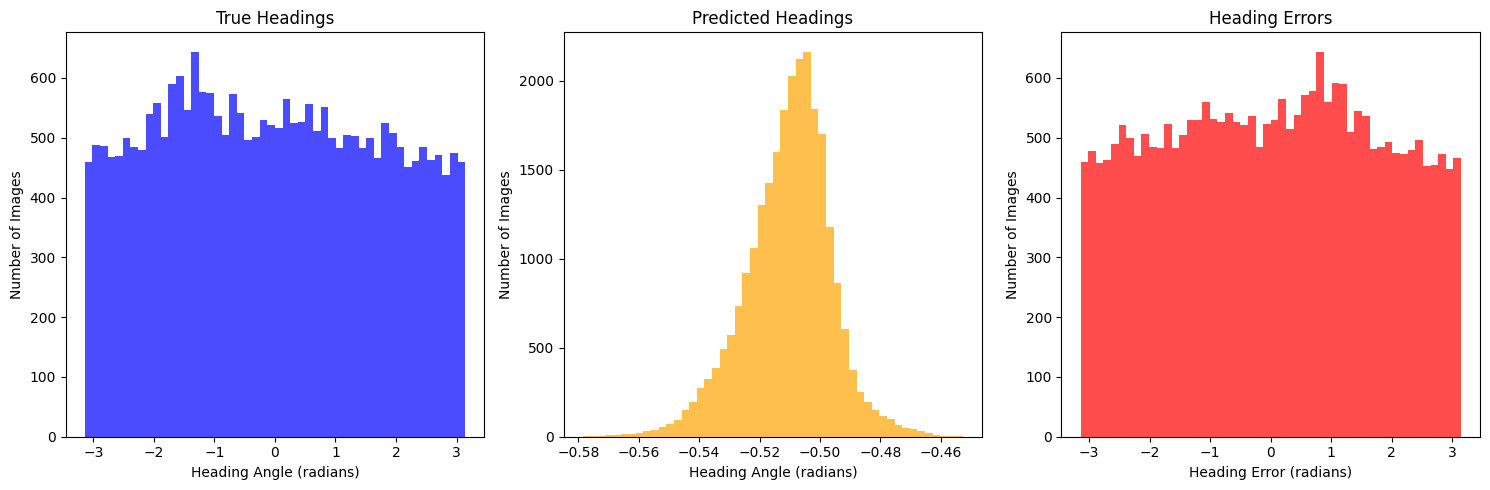

Epoch 1/100
50/50 [==============================] - 21s 408ms/step - loss: 0.0024 - val_loss: 0.0065
Epoch 2/100
50/50 [==============================] - 19s 377ms/step - loss: -0.0055 - val_loss: 0.0070
Epoch 3/100
50/50 [==============================] - 19s 383ms/step - loss: -0.0074 - val_loss: 0.0074
Epoch 4/100
50/50 [==============================] - 19s 387ms/step - loss: -0.0090 - val_loss: 0.0075
Epoch 5/100
50/50 [==============================] - 19s 382ms/step - loss: -0.0102 - val_loss: 0.0075
Epoch 6/100
50/50 [==============================] - 19s 389ms/step - loss: -0.0110 - val_loss: 0.0074
Epoch 7/100
50/50 [==============================] - 19s 381ms/step - loss: -0.0115 - val_loss: 0.0072
Epoch 8/100
50/50 [==============================] - 19s 385ms/step - loss: -0.0119 - val_loss: 0.0071
Epoch 9/100
50/50 [==============================] - 20s 391ms/step - loss: -0.0122 - val_loss: 0.0070
Epoch 10/100
50/50 [==============================] - 19s 381ms/step - los

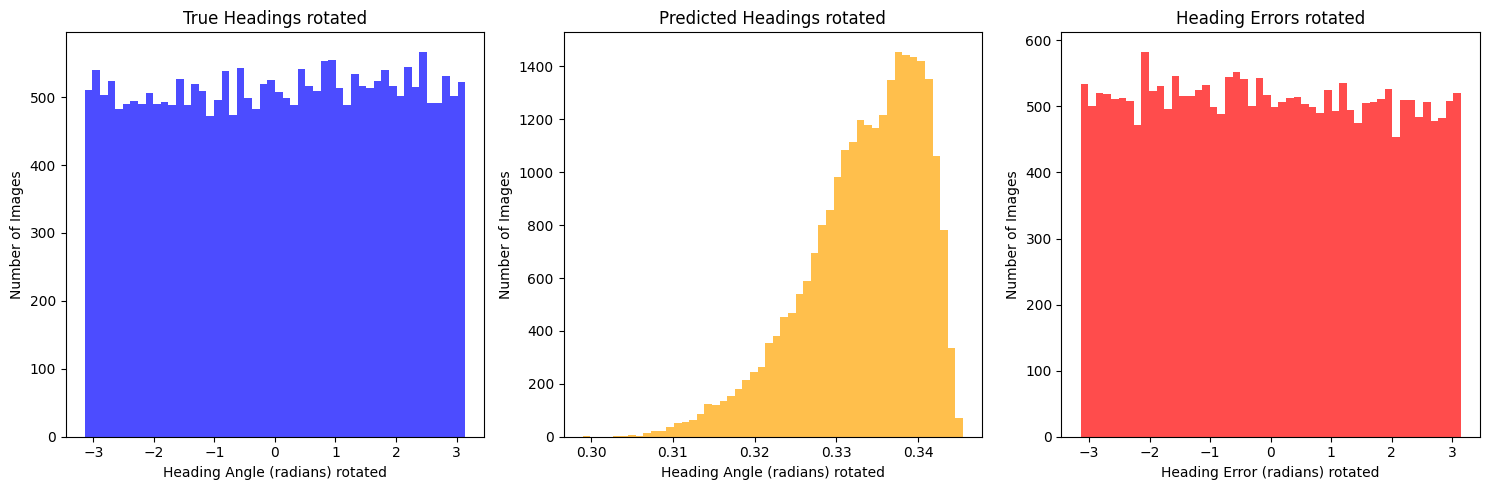

100%|██████████| 59/59 [05:21<00:00,  5.46s/it]


Epoch 1/100
49/49 [==============================] - 21s 413ms/step - loss: 0.0201 - val_loss: -0.0290
Epoch 2/100
49/49 [==============================] - 19s 391ms/step - loss: -0.0519 - val_loss: -0.0224
Epoch 3/100
49/49 [==============================] - 19s 391ms/step - loss: -0.0519 - val_loss: -0.0228
Epoch 4/100
49/49 [==============================] - 19s 392ms/step - loss: -0.0520 - val_loss: -0.0220
Epoch 5/100
49/49 [==============================] - 19s 383ms/step - loss: -0.0521 - val_loss: -0.0230
Epoch 6/100
49/49 [==============================] - 19s 383ms/step - loss: -0.0521 - val_loss: -0.0233
Epoch 7/100
49/49 [==============================] - 19s 384ms/step - loss: -0.0522 - val_loss: -0.0228
Epoch 8/100
49/49 [==============================] - 19s 382ms/step - loss: -0.0523 - val_loss: -0.0206
Epoch 9/100
49/49 [==============================] - 19s 386ms/step - loss: -0.0518 - val_loss: -0.0254
Epoch 10/100
49/49 [==============================] - 19s 382ms/s

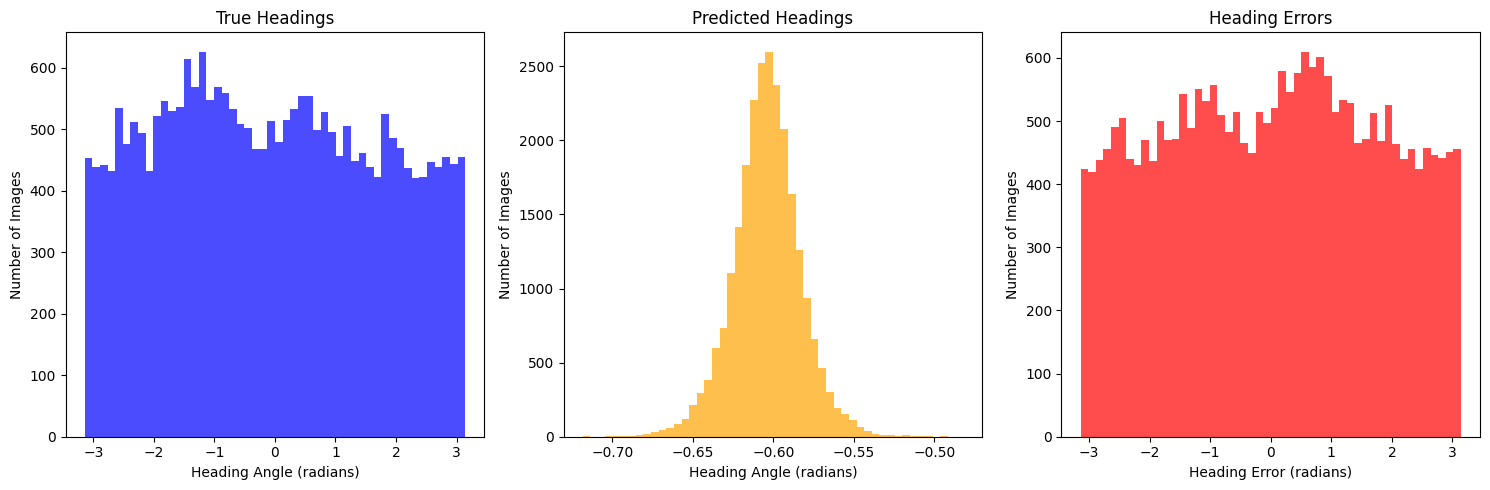

Epoch 1/100
49/49 [==============================] - 27s 552ms/step - loss: -0.0037 - val_loss: -0.0031
Epoch 2/100
49/49 [==============================] - 35s 722ms/step - loss: -0.0071 - val_loss: -0.0042
Epoch 3/100
49/49 [==============================] - 25s 503ms/step - loss: -0.0074 - val_loss: -0.0035
Epoch 4/100
49/49 [==============================] - 19s 390ms/step - loss: -0.0074 - val_loss: -0.0063
Epoch 5/100
49/49 [==============================] - 19s 396ms/step - loss: -0.0072 - val_loss: -0.0073
Epoch 6/100
49/49 [==============================] - 19s 398ms/step - loss: -0.0083 - val_loss: -0.0077
Epoch 7/100
49/49 [==============================] - 19s 391ms/step - loss: -0.0093 - val_loss: -0.0114
Epoch 8/100
49/49 [==============================] - 20s 400ms/step - loss: -0.0091 - val_loss: -0.0095
Epoch 9/100
49/49 [==============================] - 19s 388ms/step - loss: -0.0115 - val_loss: -0.0039
Epoch 10/100
49/49 [==============================] - 19s 396ms/

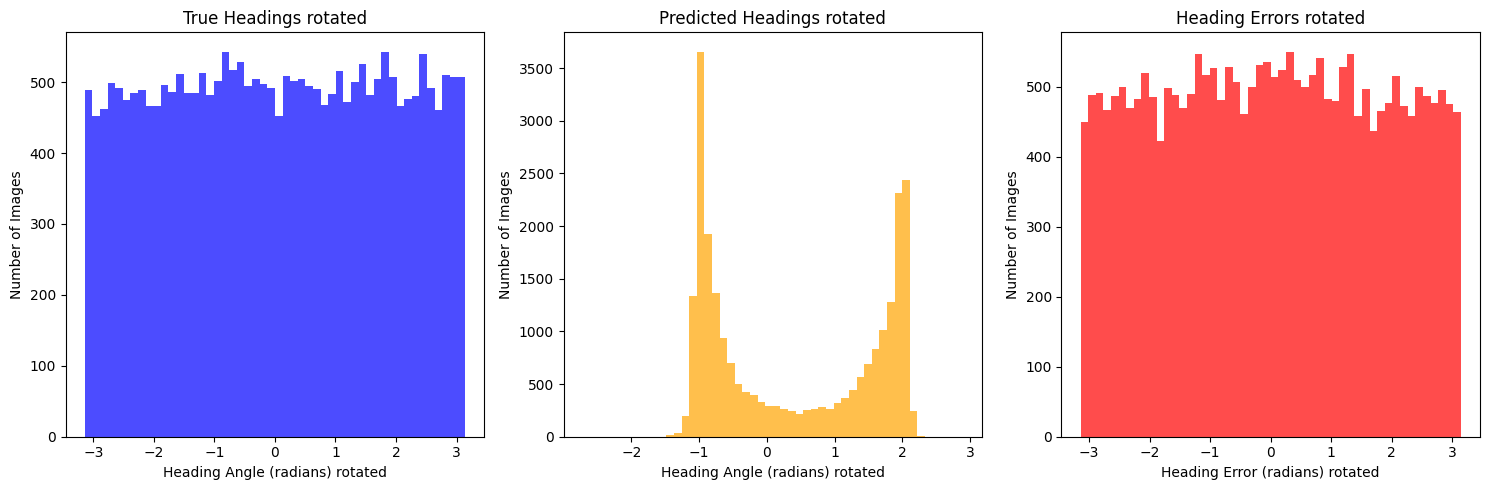

100%|██████████| 59/59 [05:37<00:00,  5.73s/it]


Epoch 1/100
47/47 [==============================] - 21s 414ms/step - loss: -0.0519 - val_loss: -0.0286
Epoch 2/100
47/47 [==============================] - 18s 392ms/step - loss: -0.0622 - val_loss: -0.0221
Epoch 3/100
47/47 [==============================] - 19s 396ms/step - loss: -0.0592 - val_loss: -0.0342
Epoch 4/100
47/47 [==============================] - 25s 531ms/step - loss: -0.0633 - val_loss: -0.0533
Epoch 5/100
47/47 [==============================] - 19s 396ms/step - loss: -0.0588 - val_loss: -0.0269
Epoch 6/100
47/47 [==============================] - 18s 391ms/step - loss: -0.0588 - val_loss: -0.0252
Epoch 7/100
47/47 [==============================] - 18s 394ms/step - loss: -0.0592 - val_loss: -0.0246
Epoch 8/100
47/47 [==============================] - 19s 398ms/step - loss: -0.0605 - val_loss: -0.0275
Epoch 9/100
47/47 [==============================] - 19s 399ms/step - loss: -0.0641 - val_loss: -0.0261
Epoch 10/100
47/47 [==============================] - 18s 394ms/

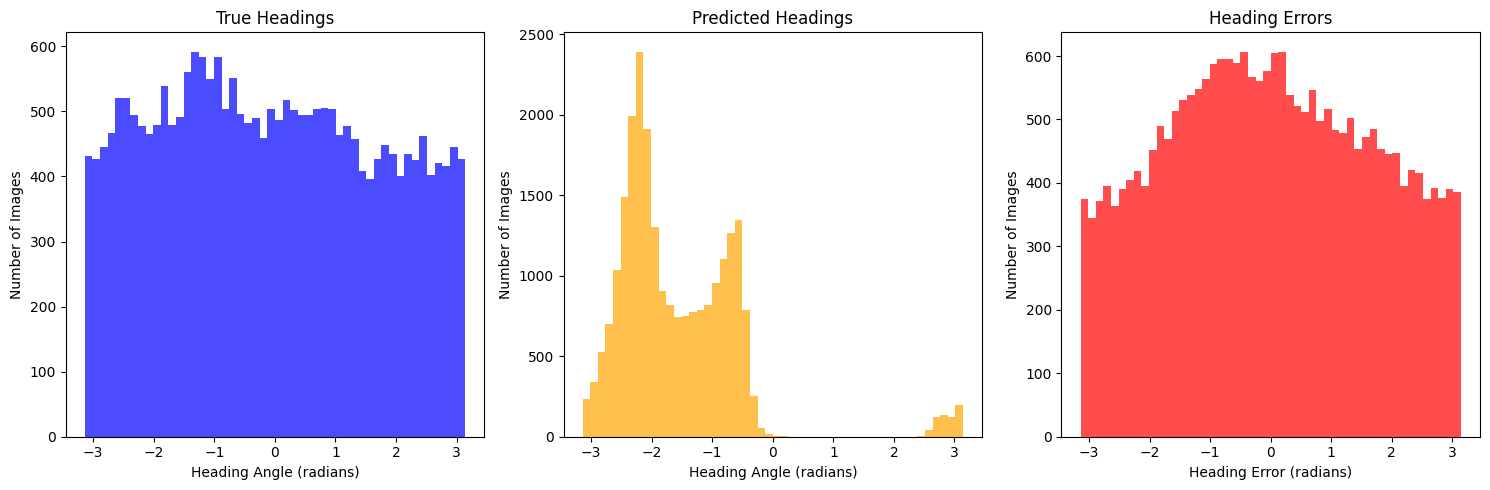

Epoch 1/100
47/47 [==============================] - 19s 398ms/step - loss: -0.0048 - val_loss: 0.0012
Epoch 2/100
47/47 [==============================] - 19s 397ms/step - loss: -0.0011 - val_loss: 9.9566e-04
Epoch 3/100
47/47 [==============================] - 18s 381ms/step - loss: -0.0025 - val_loss: 1.3152e-04
Epoch 4/100
47/47 [==============================] - 18s 383ms/step - loss: -0.0030 - val_loss: -5.0060e-04
Epoch 5/100
47/47 [==============================] - 18s 391ms/step - loss: -0.0032 - val_loss: -0.0019
Epoch 6/100
47/47 [==============================] - 18s 384ms/step - loss: -0.0042 - val_loss: -0.0071
Epoch 7/100
47/47 [==============================] - 18s 380ms/step - loss: -0.0048 - val_loss: 5.2237e-04
Epoch 8/100
47/47 [==============================] - 18s 386ms/step - loss: -0.0027 - val_loss: -5.6565e-04
Epoch 9/100
47/47 [==============================] - 18s 385ms/step - loss: -0.0031 - val_loss: -6.6236e-05
Epoch 10/100
47/47 [========================

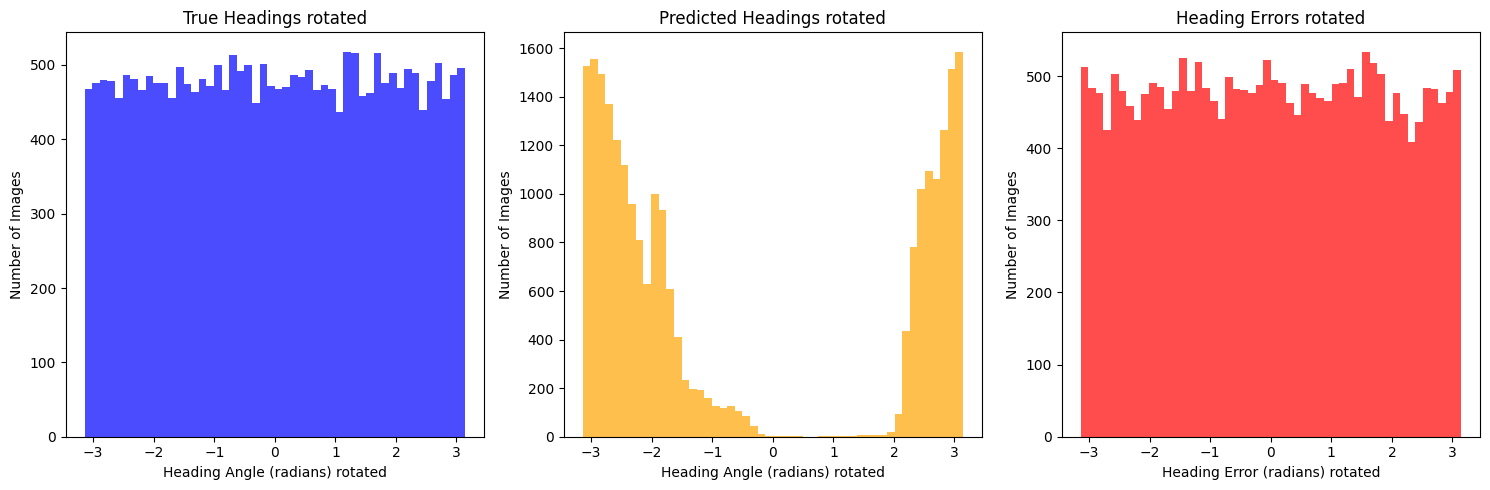

100%|██████████| 59/59 [05:36<00:00,  5.71s/it]


Epoch 1/100
47/47 [==============================] - 31s 649ms/step - loss: -0.0480 - val_loss: -0.0360
Epoch 2/100
47/47 [==============================] - 34s 725ms/step - loss: -0.0549 - val_loss: -0.0317
Epoch 3/100
47/47 [==============================] - 20s 419ms/step - loss: -0.0553 - val_loss: -0.0346
Epoch 4/100
47/47 [==============================] - 19s 402ms/step - loss: -0.0558 - val_loss: -0.0290
Epoch 5/100
47/47 [==============================] - 19s 398ms/step - loss: -0.0564 - val_loss: -0.0323
Epoch 6/100
47/47 [==============================] - 19s 403ms/step - loss: -0.0564 - val_loss: -0.0358
Epoch 7/100
47/47 [==============================] - 18s 392ms/step - loss: -0.0619 - val_loss: -0.0467
Epoch 8/100
47/47 [==============================] - 19s 398ms/step - loss: -0.0563 - val_loss: -0.0359
Epoch 9/100
47/47 [==============================] - 19s 409ms/step - loss: -0.0579 - val_loss: -0.0422
Epoch 10/100
47/47 [==============================] - 18s 392ms/

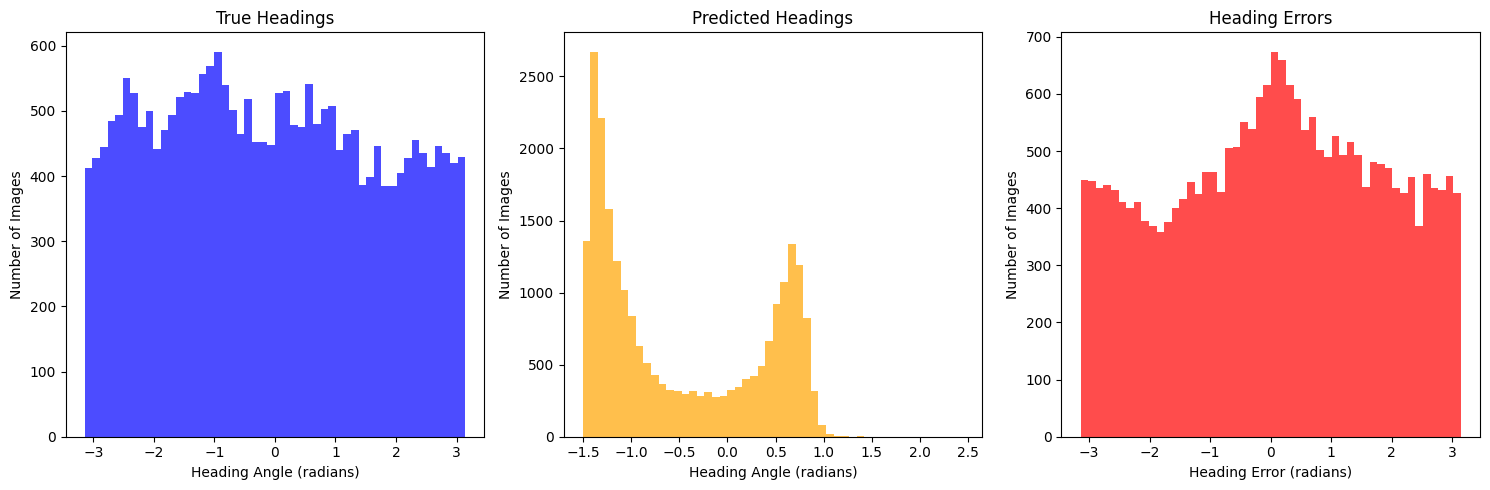

Epoch 1/100
47/47 [==============================] - 36s 760ms/step - loss: 0.0094 - val_loss: -6.7277e-04
Epoch 2/100
47/47 [==============================] - 18s 392ms/step - loss: 0.0090 - val_loss: -5.7485e-04
Epoch 3/100
47/47 [==============================] - 18s 386ms/step - loss: 0.0082 - val_loss: -4.9513e-04
Epoch 4/100
47/47 [==============================] - 18s 389ms/step - loss: 0.0076 - val_loss: -3.9861e-04
Epoch 5/100
47/47 [==============================] - 18s 393ms/step - loss: 0.0072 - val_loss: -3.2261e-04
Epoch 6/100
47/47 [==============================] - 18s 391ms/step - loss: 0.0066 - val_loss: -2.5958e-04
Epoch 7/100
47/47 [==============================] - 19s 397ms/step - loss: 0.0061 - val_loss: -2.3536e-04
Epoch 8/100
47/47 [==============================] - 18s 392ms/step - loss: 0.0054 - val_loss: -1.0853e-04
Epoch 9/100
47/47 [==============================] - 18s 389ms/step - loss: 0.0047 - val_loss: 5.7068e-05
Epoch 10/100
47/47 [==================

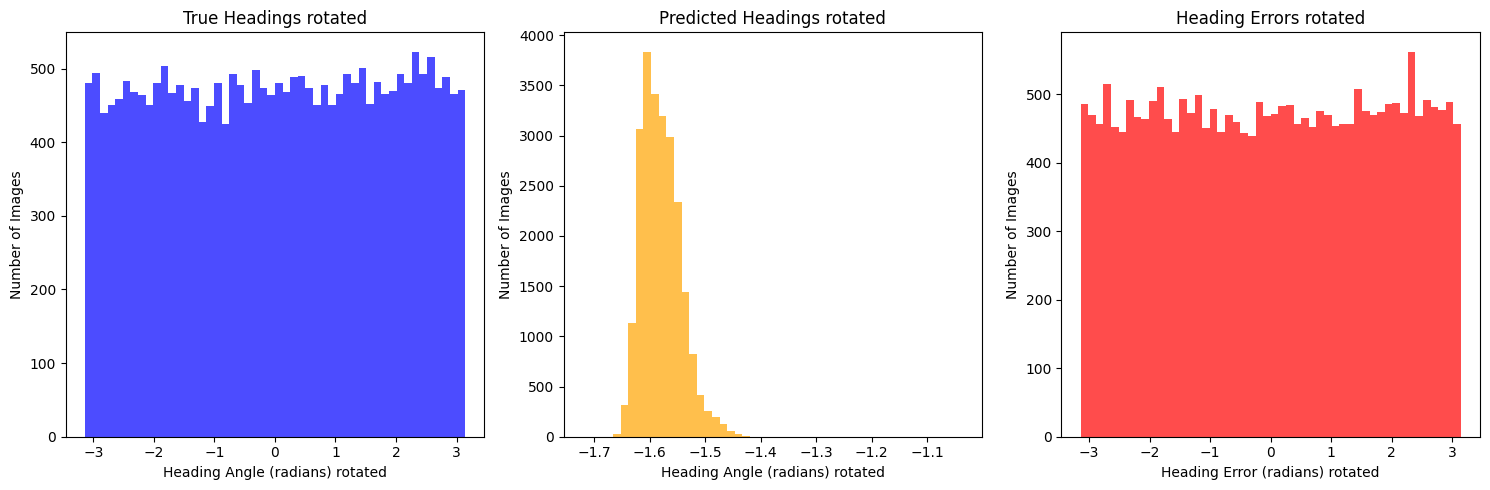

100%|██████████| 59/59 [09:02<00:00,  9.19s/it]


In [ ]:
# Define lists of parameters to loop over
image_sizes = [64,128,256]
steps = [1,3,5,7,10]
lags = [1,3,5,7,10]

# Loop over parameter combinations
for image_size in image_sizes:
    for step in steps:
        for lag in lags:
            # Train and visualize results for non-rotated and rotated images
            results = train_and_visualize(image_size, step, lag)
            for result in results:
                label, true_angles, predicted_angles, heading_errors = result
                # Visualize results here
                # Visualize results
    plt.figure(figsize=(15, 5))

    # Visualize true headings
    plt.subplot(1, 3, 1)
    plt.hist(true_angles, bins=50, color='blue', alpha=0.7)
    plt.title('True Headings')
    plt.xlabel('Heading Angle (radians)')
    plt.ylabel('Number of Images')

    # Visualize predicted headings
    plt.subplot(1, 3, 2)
    plt.hist(predicted_angles, bins=50, color='orange', alpha=0.7)
    plt.title('Predicted Headings')
    plt.xlabel('Heading Angle (radians)')
    plt.ylabel('Number of Images')

    # Visualize heading errors
    plt.subplot(1, 3, 3)
    plt.hist(heading_errors, bins=50, color='red', alpha=0.7)
    plt.title('Heading Errors')
    plt.xlabel('Heading Error (radians)')
    plt.ylabel('Number of Images')

    plt.tight_layout()
    plt.show()

    # Visualize results
    plt.figure(figsize=(15, 5))

    # Visualize true headings
    plt.subplot(1, 3, 1)
    plt.hist(true_angles_rotated, bins=50, color='blue', alpha=0.7)
    plt.title('True Headings rotated')
    plt.xlabel('Heading Angle (radians) rotated')
    plt.ylabel('Number of Images')

    # Visualize predicted headings
    plt.subplot(1, 3, 2)
    plt.hist(predicted_angles_rotated, bins=50, color='orange', alpha=0.7)
    plt.title('Predicted Headings rotated')
    plt.xlabel('Heading Angle (radians) rotated')
    plt.ylabel('Number of Images')

    # Visualize heading errors
    plt.subplot(1, 3, 3)
    plt.hist(heading_errors_rotated, bins=50, color='red', alpha=0.7)
    plt.title('Heading Errors rotated')
    plt.xlabel('Heading Error (radians) rotated')
    plt.ylabel('Number of Images')

    plt.tight_layout()
    plt.show()